## Load both matlab & python data

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy.io
import sys

np.set_printoptions(threshold=sys.maxsize)


var = scipy.io.loadmat('/home/wslvivek/Desktop/Jnb/tws_matlab/tws_m.mat');
tws_m_temp = [[element for element in upperElement] for upperElement in var['tws_m']]
tws_m_temp = np.array(tws_m_temp, dtype ='double')



import numpy as np
tws_py_temp = np.load('/home/wslvivek/Desktop/Jnb/tws_python/tws_py.npy');
tws_py_temp = np.double(tws_py_temp)

In [2]:
type(tws_m_temp[0,0,0])

numpy.float64

## Calulate area of each grid for griwise weighing
## and prepare latitude, longitudes & time axis to write to netCDFs

In [3]:
lon = np.arange(-180,180,1)
lat = np.arange(89,-91,-1)
import pickle
#with open("/home/wslvivek/Desktop/level2/Spyder/dates", "rb") as fp:   # Unpickling
#    dates = pickle.load(fp)
dates = np.arange(0,196,1)



In [4]:
# Calculation of area of each corresponding to  the latitudes and longitudes
deg = 1.0;
x = np.linspace(0, 359+(1-deg), int(360/deg), dtype='double');
y = np.linspace(0, 179+(1-deg), int(180/deg), dtype='double');
x1 = np.linspace(1*deg, 360, int(360/deg), dtype='double');
y1 = np.linspace(1*deg, 180, int(180/deg), dtype='double');
lambd,theta = np.meshgrid(x,y)  
lambd1,theta1 = np.meshgrid(x1,y1)  
a = np.sin(np.deg2rad(90-theta))-np.sin(np.deg2rad(90-theta1))
b = (lambd1 - lambd)*np.pi/180

# Area of each grid (360*720)
area = (6378.137**2)*pow(10,6)*(np.multiply(a,b))        # units m^2
tot_area = np.sum(np.sum(area))

tws_m, tws_py = np.zeros([196,180,360]), np.zeros([196,180,360])
for i in range(0,196,1):
    tws_m[i,:,:] = np.multiply(tws_m_temp[i,:,:],area)/tot_area
    tws_py[i,:,:] = np.multiply(tws_py_temp[i,:,:],area)/tot_area
    

In [ ]:
area

In [5]:
tws_d = tws_m - tws_py
tws_d = np.longdouble(tws_d)

In [6]:
ds_m = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_m)
    ),
    coords = {
        "time":dates,
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS using MATLAB, Anomaly corresponding to long term (2004-2010) mean"),
)

ds_py = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_py)
    ),
    coords = {
        "time":dates,
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS using Python, Anomaly corresponding to long term (2004-2010) mean"),
)

ds_d = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_d)
    ),
    coords = {
        "time":dates,
        "lat":lat,
        "lon":lon },
    attrs=dict(description="Difference of MATLAB & Python solutions, gridwise"),
)

In [7]:
ds_m.info()
ds_py.info()
ds_d.info()

xarray.Dataset {
dimensions:
	time = 196 ;
	lat = 180 ;
	lon = 360 ;

variables:
	float64 tws(time, lat, lon) ;
	int64 time(time) ;
	int64 lat(lat) ;
	int64 lon(lon) ;

// global attributes:
	:description = TWS using MATLAB, Anomaly corresponding to long term (2004-2010) mean ;
}xarray.Dataset {
dimensions:
	time = 196 ;
	lat = 180 ;
	lon = 360 ;

variables:
	float64 tws(time, lat, lon) ;
	int64 time(time) ;
	int64 lat(lat) ;
	int64 lon(lon) ;

// global attributes:
	:description = TWS using Python, Anomaly corresponding to long term (2004-2010) mean ;
}xarray.Dataset {
dimensions:
	time = 196 ;
	lat = 180 ;
	lon = 360 ;

variables:
	float128 tws(time, lat, lon) ;
	int64 time(time) ;
	int64 lat(lat) ;
	int64 lon(lon) ;

// global attributes:
	:description = Difference of MATLAB & Python solutions, gridwise ;
}

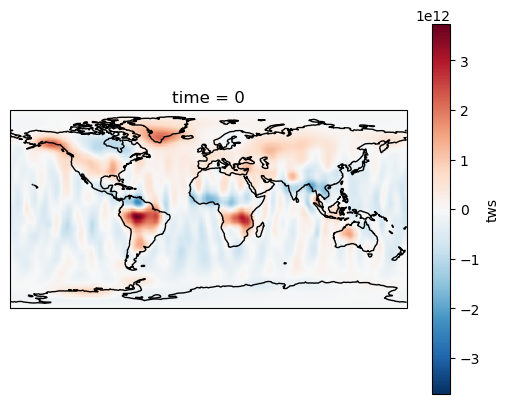

In [10]:
fig = plt.figure()
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
ds_py.tws[0,:,:].plot()

# Interactive plot of difference

In [ ]:
import hvplot.xarray
import panel.widgets as pnw
fig = plt.figure()
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ds_py.tws.interactive.sel(time=pnw.DiscreteSlider).plot()
ax.coastlines()

# Apply mask

In [9]:
import salem
import cartopy.crs as ccrs
from shapely.geometry import mapping

In [11]:
#shdf = salem.read_shapefile('/home/wslvivek/Desktop/garca/vivek/Ganga.shp')
#shdf = salem.read_shapefile('/home/wslvivek/Desktop/garca/vivek/India_basins.shp')
#shdf = salem.read_shapefile('/home/wslvivek/Desktop/assign2/Antarctica_shapefile/Antarctica_gpd.shp')
#shdf = salem.read_shapefile('/home/wslvivek/Desktop/assign2/Greenland_shapefile/Greenland_gpd.shp')

#ds_m_mask = ds_m.salem.roi(shape=shdf)
#ds_py_mask = ds_py.salem.roi(shape=shdf)

ds_m_mask = ds_m
ds_py_mask = ds_py

Text(0, 0.5, 'Water thickness anomaly in mm')

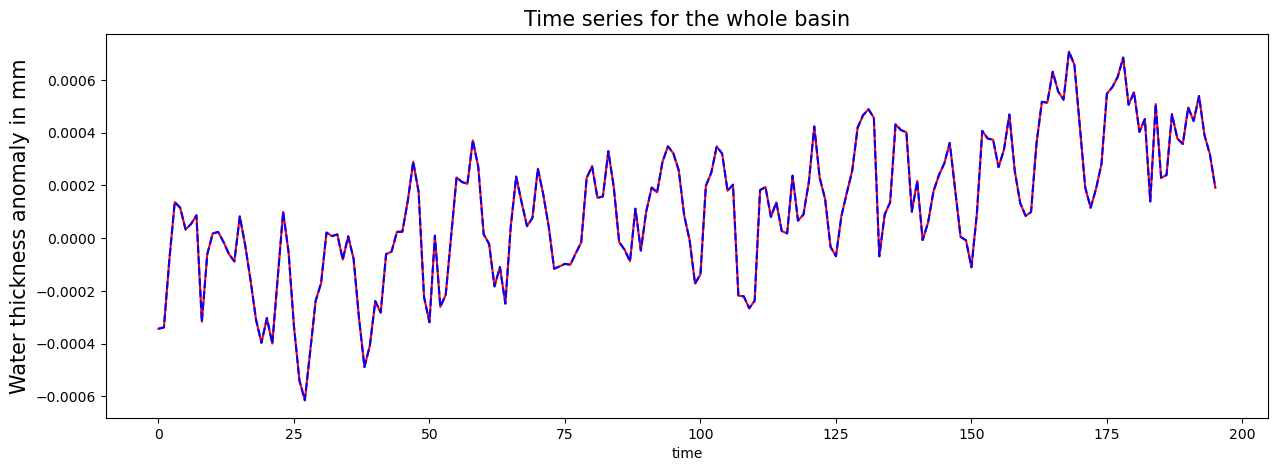

In [12]:
alpha_m = ds_m_mask.tws.sum(dim=('lon','lat')) 
alpha_py = ds_py_mask.tws.sum(dim=('lon','lat')) 
# Time series for the whole basin(shapefile) in user defined range
fig,ax=plt.subplots(figsize=(15,5))
alpha_m.isel(time=slice(0,196)).plot(ax=ax,color='r');
alpha_py.isel(time=slice(0,196)).plot(ax=ax,color='b', linestyle='dashed');
ax.set_box_aspect(0.33)
ax.set_title('Time series for the whole basin',size=15)
ax.set_ylabel('Water thickness anomaly in mm',size=15)

In [ ]:
alpha_py

In [ ]:
max(alpha_py), max(alpha_m)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,8))
fig.suptitle('TWSC summed over all grids')

ax1.plot(alpha_m, color='b')
ax1.set_ylabel('MATLAB--solution')

ax2.plot(alpha_py, color='r', linestyle='dashed')
ax2.set_xlabel('time (months)')
ax2.set_ylabel('Python--solution')

plt.show()

In [ ]:
plt.plot(alpha_m-alpha_py)